In [1]:
from numpy import linalg as LA
import os
import pandas as pd
import numpy as np
from scipy.signal import find_peaks_cwt
import pickle
from pathlib import Path
from scipy.stats import kurtosis, skew
from scipy.stats import iqr
from pyentrp import entropy as ent
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, LSTMCell
from keras.layers import Dropout
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize
import sys
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
import math
from tony_beltramelli_detect_peaks import detect_peaks

%matplotlib inline

/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
roll = [0.12, 2.56, -5.67, 8.432]

rms_roll = np.sqrt(np.mean([x**2 for x in roll]))

print rms_roll

5.239645121570734


In [3]:
in_dir = "data_3_8_2018"

## Compute features for accelerometer only

In [4]:
#Helper Functions

def Signal_magnitude_area(x,y,z):

        sum = 0    
        for i in range(len(x)):
            sum += (abs(x[i]) + abs(y[i]) + abs(z[i]))

        return float(sum)/len(x)


def Power(x):

    power = (LA.norm(x)**2)/ len(x)
    return power


def number_of_peaks(window):
    indexes = find_peaks_cwt(window, np.arange(1, len(window)))
    return len(indexes)


def number_of_peaks2(window):

    print('Detect peaks with height threshold.')
    indexes = detect_peaks(vector, 1.5)
    return len(indexes)

    
def compute_accelerometer(in_dir, features, labels, ignore_pickle=False):
    
    trim_num_seconds = 10
    acc_freq = 4
    window_num_seconds = 4 #seconds
    steps_per_sec = int(1000/acc_freq)
    window_size = int(window_num_seconds*steps_per_sec)
    window_step = 2 #seconds
    window_jump_steps = int(window_step*steps_per_sec)

    print("Window_size, Window_jump_steps: ", window_size, window_jump_steps)

    #this function assumes that records are evenly spaced
    def trim_first_last_n_seconds(df, n, freq):
        if df.shape[0] < 6001:
            return None

        remove_indexes = list(range(0, int(n*1000/freq)))
        df = df.drop(remove_indexes)

        remove_indexes = list(range(df.shape[0] - int(n*1000/freq), df.shape[0]-1))
        df = df.drop(remove_indexes)

        return df


    dfs_list = []
    #features = []
    #labels = []

    bypass = True

    pickle_file = Path("pickles/accelerometer_features.pickle")

    if pickle_file.exists() and not ignore_pickle:
        print("Found pickle files for accelerometer")

        features = pickle.load(open("pickles/accelerometer_features.pickle", "rb"))
        labels = pickle.load(open("pickles/accelerometer_labels.pickle", "rb"))
        dfs_list = pickle.load(open("pickles/accelerometer_dfs_list.pickle", "rb"))

    else:

        for root, dirs, files in os.walk(in_dir):
            path = root.split(os.sep)

            for f in files:
                print("/".join(path) + "/" + f)

                full_path = "/".join(path) + "/" + f

                if "gyroscope" in full_path:
                    print("Skip ", full_path)
                    continue

                df = pd.read_csv(full_path, header=None)

                print("Before trimming: ", df.shape)

                df = trim_first_last_n_seconds(df, trim_num_seconds, acc_freq)
                if df is None:
                    print("Continuing")
                    continue

                print("After trimming: ", df.shape)

                #Sample the data according to the size of the window with 50% overlap
                for index in range(0, df.shape[0]-window_size, window_jump_steps):
                    indexes = list(range(index, index + int(window_size)))

                    window = df.iloc[indexes,:]

                    X_list = window[1].tolist()
                    Y_list = window[2].tolist()
                    Z_list = window[3].tolist()


                    #Generate the features for this window


           # ****************** Time-Domain Features ************************* #

                    #Mean of the signals
                    mean_x = np.mean(X_list)
                    mean_y = np.mean(Y_list)
                    mean_z = np.mean(Z_list)

                    #Variance of the signals
                    var_x = np.var(X_list)
                    var_y = np.var(Y_list)
                    var_z = np.var(Z_list)

                    #Number of peaks in the signals
                    #num_peaks_x = number_of_peaks(X_list)
                    #num_peaks_y = number_of_peaks(Y_list)
                    #num_peaks_z = number_of_peaks(Z_list)            

                    #Median of the signals
                    median_x = np.ma.median(X_list)
                    median_y = np.ma.median(Y_list)
                    median_z = np.ma.median(Z_list)

                    #Standard Deviation of the signals
                    std_x = np.std(X_list)
                    std_y = np.std(Y_list)
                    std_z = np.std(Z_list)

                    #Compute Signal Magnitude Area
                    signal_mag_area = Signal_magnitude_area(X_list, Y_list, Z_list)

                    #Maximum and Minimum values and their indexes
                    max_x = max(X_list)
                    #max_index_x = X_list.index(max_x)               
                    min_x = min(X_list)
                    #min_index_x = X_list.index(min_x)

                    max_y = max(Y_list)
                   #max_index_y = Y_list.index(max_y)              
                    min_y = min(Y_list)
                    #min_index_y = Y_list.index(min_y)               

                    max_z = max(Z_list)
                    #max_index_z = Z_list.index(max_z)             
                    min_z = min(Z_list)
                    #min_index_z = Z_list.index(min_z)


                    #Power of X,Y and Z signals             
                    power_x = Power(X_list)
                    power_y = Power(Y_list)
                    power_z = Power(Z_list)


                    #Skewness and Kurtosis
                    skew_x = skew(X_list)
                    skew_y = skew(Y_list)
                    skew_z = skew(Z_list)

                    kurtosis_x = kurtosis(X_list)                
                    kurtosis_y = kurtosis(Y_list)
                    kurtosis_z = kurtosis(Z_list)


                    #Entropy of the signals (Can experiment with different types of Entropy)
                    entropy_x = ent.shannon_entropy(X_list)
                    entropy_y = ent.shannon_entropy(Y_list)
                    entropy_z = ent.shannon_entropy(Z_list)


                    #Interquartile range of the signals
                    iqr_x = iqr(X_list)
                    iqr_y = iqr(Y_list)
                    iqr_z = iqr(Z_list)


                    #Cross Correlation 
                    corr_x_y = np.correlate(X_list, Y_list)[0]
                    corr_y_z = np.correlate(Y_list, Z_list)[0]
                    corr_x_z = np.correlate(X_list, Z_list)[0]


                    
                    #Pitch and Roll Information (for rotation)
                    roll = []
                    pitch = []
                    for index in range(0,len(X_list)):                       
                        roll.append(math.atan2(Y_list[index]/9.81, Z_list[index]/9.81) * 57.3)
                        pitch.append(math.atan2(X_list[index]/9.81, Z_list[index]/9.81) * 57.3)
                    
                    #Mean of the roll and pitch
                    mean_roll = np.mean(roll)
                    mean_pitch = np.mean(pitch)
                    
                    #RMS of roll and pitch
                    #rms_roll = np.sqrt(np.mean(roll**2))
                    rms_roll = np.sqrt(np.mean([x**2 for x in roll]))
                    rms_pitch = np.sqrt(np.mean([x**2 for x in pitch]))            
                    #rms_pitch = np.sqrt(np.mean(pitch**2))
                                      
                    #Zero Crossing Rate for roll and pitch
                    frame = roll
                    count = len(frame)
                    countZ = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
                    zcr_roll = np.float64(countZ) / np.float64(count-1.0)
                    
                    frame = pitch
                    count = len(frame)
                    countZ = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
                    zcr_pitch = np.float64(countZ) / np.float64(count-1.0)
                    

        # ****************** Frequency-Domain Features ************************* #


                    coeff_X = np.fft.fft(X_list)
                    coeff_Y = np.fft.fft(Y_list)
                    coeff_Z = np.fft.fft(Z_list)


                    #Normalized FFT coefficients
                    fft_x = LA.norm(coeff_X)              
                    fft_y = LA.norm(coeff_Y)   
                    fft_z = LA.norm(coeff_Z)  


                    #Energy in the frequency Domain
                    Energy_x = sum(abs(coeff_X**2))/len(X_list)
                    #sum(abs(coeff_X)**2)/len(x1)
                    Energy_y = sum(abs(coeff_Y**2))/len(Y_list)
                    Energy_z = sum(abs(coeff_Z**2))/len(Z_list)


                    #Store the features
                    window_feature = []
                    window_feature.append(mean_x)
                    window_feature.append(mean_y)
                    window_feature.append(mean_z)

                    window_feature.append(var_x)
                    window_feature.append(var_y)
                    window_feature.append(var_z)

                    window_feature.append(median_x)
                    window_feature.append(median_y)
                    window_feature.append(median_z)

                    window_feature.append(std_x)
                    window_feature.append(std_y)
                    window_feature.append(std_z)


                    window_feature.append(signal_mag_area)

                    window_feature.append(max_x)
                    #window_feature.append(max_index_x)
                    window_feature.append(min_x)
                    #window_feature.append(min_index_x)

                    window_feature.append(max_y)
                    #window_feature.append(max_index_y)
                    window_feature.append(min_y)
                    #window_feature.append(min_index_y)

                    window_feature.append(max_z)
                    #window_feature.append(max_index_z)
                    window_feature.append(min_z)
                    #window_feature.append(min_index_z)

                    window_feature.append(power_x)
                    window_feature.append(power_y)
                    window_feature.append(power_z)

                    window_feature.append(skew_x)
                    window_feature.append(kurtosis_x) 

                    window_feature.append(skew_y)
                    window_feature.append(kurtosis_y) 

                    window_feature.append(skew_z)
                    window_feature.append(kurtosis_z) 

                    window_feature.append(entropy_x)
                    window_feature.append(entropy_y)
                    window_feature.append(entropy_z)

                    window_feature.append(iqr_x)
                    window_feature.append(iqr_y)
                    window_feature.append(iqr_z)

                    window_feature.append(corr_x_y)
                    window_feature.append(corr_y_z)
                    window_feature.append(corr_x_z)
                    
                    window_feature.append(mean_roll)
                    window_feature.append(mean_pitch)
                    window_feature.append(rms_roll)
                    window_feature.append(rms_pitch)
                    
                    window_feature.append(zcr_roll)
                    window_feature.append(zcr_pitch)

                    window_feature.append(fft_x)
                    window_feature.append(fft_y)
                    window_feature.append(fft_z)

                    window_feature.append(Energy_x)
                    window_feature.append(Energy_y)
                    window_feature.append(Energy_z)

                    #window_feature.append(num_peaks_x)
                    #window_feature.append(num_peaks_y)
                    #window_feature.append(num_peaks_z)

                    #scale = preprocessing.minmax_scale(data, feature_range=(-0.5, 0.5))

                    features.append(window_feature)

                    #Store the label
                    labels.append(df[5].iloc[1])

                dfs_list.append(df)

        dfs = pd.concat(dfs_list)

        if not ignore_pickle:

            pickle.dump(features, open("pickles/accelerometer_features.pickle", "wb"), protocol=2)
            pickle.dump(labels, open("pickles/accelerometer_labels.pickle", "wb"), protocol=2)
            pickle.dump(dfs_list, open("pickles/accelerometer_dfs_list.pickle", "wb"), protocol=2)

    features = np.asarray(features)
    labels = np.asarray(labels)
    
    return features, labels

In [37]:
train = True
test = True

test_dir = 'test3'
train_dir = 'data_3_8_2018'

if train:
    features = []
    labels = []
    features, labels = compute_accelerometer(train_dir, features, labels, ignore_pickle=False)
    
if test:
    test_features = []
    test_labels = []
    test_features, test_labels = compute_accelerometer(test_dir, test_features, test_labels, ignore_pickle=True)

print features.shape
print test_features.shape

('Window_size, Window_jump_steps: ', 1000, 500)
Found pickle files for accelerometer
('Window_size, Window_jump_steps: ', 1000, 500)
test3/0_1_android.sensor.accelerometer.data.csv
('Before trimming: ', (50530, 6))
('After trimming: ', (45531, 6))
test3/0_4_android.sensor.gyroscope.data.csv
('Skip ', 'test3/0_4_android.sensor.gyroscope.data.csv')
test3/10_1_android.sensor.accelerometer.data.csv
('Before trimming: ', (60055, 6))
('After trimming: ', (55056, 6))
test3/10_4_android.sensor.gyroscope.data.csv
('Skip ', 'test3/10_4_android.sensor.gyroscope.data.csv')
test3/11_1_android.sensor.accelerometer.data.csv
('Before trimming: ', (49816, 6))
('After trimming: ', (44817, 6))
test3/11_4_android.sensor.gyroscope.data.csv
('Skip ', 'test3/11_4_android.sensor.gyroscope.data.csv')
test3/12_1_android.sensor.accelerometer.data.csv
('Before trimming: ', (60027, 6))
('After trimming: ', (55028, 6))
test3/12_4_android.sensor.gyroscope.data.csv
('Skip ', 'test3/12_4_android.sensor.gyroscope.data.

In [38]:
def get_non_walking(lst, bools):
    nl = []
    for i,j in zip(lst,bools):
        if(j):
            nl.append(i)
    return nl
    

In [39]:
labels_ = labels
features_ = features
test_features_ = test_features
test_labels_ = test_labels

In [40]:
print(features_.shape)
#print(labels_.shape)

print(test_features_.shape)
#print(test_labels_.shape)

(11732, 49)
(1638, 49)


In [41]:
nowalk_bools = [False if  x=='walking' else True for x in labels]
test_nowalk_bools = [False if  x=='walking' else True for x in test_labels]


In [42]:
features = np.asarray(get_non_walking(features,nowalk_bools))
test_features = np.asarray(get_non_walking(test_features,test_nowalk_bools))
labels = get_non_walking(labels,nowalk_bools)
test_labels = get_non_walking(test_labels,test_nowalk_bools)

In [43]:
print(features.shape)
#print(labels.shape)

print(test_features.shape)
#print(test_labels.shape)


(8584, 49)
(1453, 49)


In [44]:
print(np.unique(labels))

['laying_down' 'sitting' 'standing']


['laying_down' 'sitting' 'standing']


(array([3004.,    0.,    0.,    0.,    0., 2842.,    0.,    0.,    0.,
        2738.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

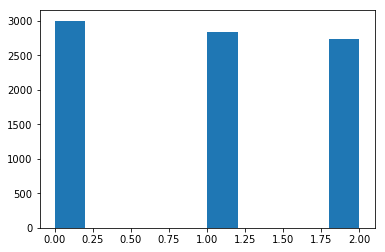

In [45]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(labels)

print(le.classes_)

plt.hist(y)

# Compute features for accelerometer and gyrometer

In [ ]:

in_dir = "data_3_4_2018"

trim_num_seconds = 10
acc_freq = 4
window_num_seconds = 4 #seconds
steps_per_sec = int(1000/acc_freq)
window_size = int(window_num_seconds*steps_per_sec)
window_step = 2 #seconds
window_jump_steps = int(window_step*steps_per_sec)

print("Window_size, Window_jump_steps: ", window_size, window_jump_steps)

def number_of_peaks(window):
    indexes = find_peaks_cwt(window, np.arange(1, len(window)))

    return len(indexes)

#this function assumes that records are evenly spaced
def trim_first_last_n_seconds(df, n, freq):
    if df.shape[0] < 6001:
        return None
    
    remove_indexes = list(range(0, int(n*1000/freq)))
    df = df.drop(remove_indexes)

    remove_indexes = list(range(df.shape[0] - int(n*1000/freq), df.shape[0]-1))
    df = df.drop(remove_indexes)
    
    return df
    
def combine_acc_gyro_data(df_acc, df_gyro):
    threshold = 10
    
    acc_index = 0
    gyro_index = 0
    
    acc_matrix = df_acc.as_matrix()
    gyro_matrix = df_gyro.as_matrix()
    
    combined_list = []
    
    while (acc_index < df_acc.shape[0]) and (gyro_index < df_gyro.shape[0]):
        #find next gyro_index within threshold and append the data
        
        acc_time = df_acc.iloc[acc_index][0]
        gyro_time = df_gyro.iloc[gyro_index][0]

        if (acc_time < gyro_time):
            while (acc_index < df_acc.shape[0]) and (gyro_time - acc_time > threshold):
                acc_time = acc_matrix[acc_index][0] #df_acc.iloc[acc_index][0]
                acc_index += 1
        else:
            while (gyro_index < df_gyro.shape[0]) and (acc_time - gyro_time > threshold):
                gyro_time = gyro_matrix[gyro_index][0] #df_gyro.iloc[gyro_index][0]
                gyro_index += 1
            
        combined_list.append(np.concatenate((acc_matrix[acc_index][:4], gyro_matrix[gyro_index][1:6]), axis=0))
        acc_index += 1
        gyro_index += 1
            
    return combined_list


dfs_list = []
features = []
labels = []

pickle_file = Path("pickles/acc_gyro_features.pickle")

if pickle_file.exists():
    print("Found pickle files for accelerometer and gyroscope features combined")
    
    features = pickle.load(open("pickles/acc_gyro_features.pickle", "rb"))
    labels = pickle.load(open("pickles/acc_gyro_labels.pickle", "rb"))
    dfs_list = pickle.load(open("pickles/acc_gyro_dfs_list.pickle", "rb"))
    
else:

    for root, dirs, files in os.walk(in_dir):
        path = root.split(os.sep)

        for f in files:

            if 'accelerometer' in f:
                accelerometer_path = "/".join(path) + "/" + f
                print(accelerometer_path)

                first_ = f.find("_")
                g = f[0:first_] + "_4" + f[first_+2:]
                gyroscope_path = "/".join(path) + "/" + g.replace("accelerometer","gyroscope")
                print(gyroscope_path)

                df_acc = pd.read_csv(accelerometer_path, header=None)
                df_gyro = pd.read_csv(gyroscope_path, header=None)

                combined_list = combine_acc_gyro_data(df_acc, df_gyro)
                combined_numpy = np.array(combined_list)

                combined_df = pd.DataFrame(data=combined_numpy)

                print("Before trimming: ", combined_df.shape)

                combined_df = trim_first_last_n_seconds(combined_df, trim_num_seconds, acc_freq)
                if combined_df is None:
                    print("Continuing")
                    continue

                print("After trimming: ", combined_df.shape)

                #Sample the data according to the size of the window with 50% overlap
                for index in range(0, combined_df.shape[0]-window_size, window_jump_steps):
                    indexes = list(range(index, index + int(window_size)))

                    window = combined_df.iloc[indexes,:]

                    #Generate the features for this window
                    acc_mean_x = np.mean(window[1].tolist())
                    acc_mean_y = np.mean(window[2].tolist())
                    acc_mean_z = np.mean(window[3].tolist())

                    acc_var_x = np.var(window[1].tolist())
                    acc_var_y = np.var(window[2].tolist())
                    acc_var_z = np.var(window[3].tolist())

#                     acc_num_peaks_x = number_of_peaks(window[1].tolist())
#                     acc_num_peaks_y = number_of_peaks(window[2].tolist())
#                     acc_num_peaks_z = number_of_peaks(window[3].tolist())            

                    window_feature = []

                    window_feature.append(acc_mean_x)
                    window_feature.append(acc_mean_y)
                    window_feature.append(acc_mean_z)
                    window_feature.append(acc_var_x)
                    window_feature.append(acc_var_y)
                    window_feature.append(acc_var_z)
#                     window_feature.append(acc_num_peaks_x)
#                     window_feature.append(acc_num_peaks_y)
#                     window_feature.append(acc_num_peaks_z)


                    gyro_mean_x = np.mean(window[4].tolist())
                    gyro_mean_y = np.mean(window[5].tolist())
                    gyro_mean_z = np.mean(window[6].tolist())

                    gyro_var_x = np.var(window[4].tolist())
                    gyro_var_y = np.var(window[5].tolist())
                    gyro_var_z = np.var(window[6].tolist())

#                     gyro_num_peaks_x = number_of_peaks(window[4].tolist())
#                     gyro_num_peaks_y = number_of_peaks(window[5].tolist())
#                     gyro_num_peaks_z = number_of_peaks(window[6].tolist())            

                    #Store the features
                    
                    window_feature.append(gyro_mean_x)
                    window_feature.append(gyro_mean_y)
                    window_feature.append(gyro_mean_z)
                    window_feature.append(gyro_var_x)
                    window_feature.append(gyro_var_y)
                    window_feature.append(gyro_var_z)
#                     window_feature.append(gyro_num_peaks_x)
#                     window_feature.append(gyro_num_peaks_y)
#                     window_feature.append(gyro_num_peaks_z)

                    features.append(window_feature)

                    #Store the label
                    labels.append(combined_df[8].iloc[0])
                
                dfs_list.append(combined_df)
            
    dfs = pd.concat(dfs_list)

    pickle.dump(features, open("pickles/acc_gyro_features.pickle", "wb"), protocol=2)
    pickle.dump(labels, open("pickles/acc_gyro_labels.pickle", "wb"), protocol=2)
    pickle.dump(dfs_list, open("pickles/acc_gyro_dfs_list.pickle", "wb"), protocol=2)

features = np.asarray(features)
labels = np.asarray(labels)

## Compute LSTM features for accelerometer

In [ ]:
trim_num_seconds = 10
acc_freq = 4
window_num_seconds = 4 #seconds
steps_per_sec = int(1000/acc_freq)
window_size = int(window_num_seconds*steps_per_sec)
window_step = 2 #seconds
window_jump_steps = int(window_step*steps_per_sec)

print("Window_size, Window_jump_steps: ", window_size, window_jump_steps)

dfs_list = []
features = []
labels = []


#this function assumes that records are evenly spaced
def trim_first_last_n_seconds(df, n, freq):
    if df.shape[0] < 6001:
        return None
    
    remove_indexes = list(range(0, int(n*1000/freq)))
    df = df.drop(remove_indexes)

    remove_indexes = list(range(df.shape[0] - int(n*1000/freq), df.shape[0]-1))
    df = df.drop(remove_indexes)
    
    return df


pickle_file = Path("pickles/lstm_acc_features.pickle")

if pickle_file.exists():
    print("Found pickle files for LSTM acc and gyro")
    
    features = pickle.load(open("pickles/lstm_acc_features.pickle", "rb"))
    labels = pickle.load(open("pickles/lstm_acc_labels.pickle", "rb"))
    dfs_list = pickle.load(open("pickles/lstm_acc_dfs_list.pickle", "rb"))
    
else:

    for root, dirs, files in os.walk(in_dir):
        path = root.split(os.sep)

        for f in files:

            accelerometer_path = "/".join(path) + "/" + f
            print(accelerometer_path)

            first_ = f.find("_")
            g = f[0:first_] + "_4" + f[first_+2:]
            gyroscope_path = "/".join(path) + "/" + g.replace("accelerometer","gyroscope")
            print(gyroscope_path)

            df_acc = pd.read_csv(accelerometer_path, header=None)
            df_gyro = pd.read_csv(gyroscope_path, header=None)

            combined_list = combine_acc_gyro_data(df_acc, df_gyro)
            combined_numpy = np.array(combined_list)

            combined_df = pd.DataFrame(data=combined_numpy)

            print("Before trimming: ", combined_df.shape)

            combined_df = trim_first_last_n_seconds(combined_df, trim_num_seconds, acc_freq)
            if combined_df is None:
                print("Continuing")
                continue

            print("After trimming: ", combined_df.shape)

            #Sample the data according to the size of the window with 50% overlap
            for index in range(0, combined_df.shape[0]-window_size, window_jump_steps):
                indexes = list(range(index, index + int(window_size)))

                window = df.iloc[indexes, 1:df.shape[1]-2]

                #Generate the features for this window            
                features.append(np.asarray(window))

                #Store the label
                labels.append(df[5].iloc[0])

            dfs_list.append(df)

    dfs = pd.concat(dfs_list)
    
    pickle.dump(features, open("pickles/lstm_acc_features.pickle", "wb"), protocol=2)
    pickle.dump(labels, open("pickles/lstm_acc_labels.pickle", "wb"), protocol=2)
    pickle.dump(dfs_list, open("pickles/lstm_acc_dfs_list.pickle", "wb"), protocol=2)
    
    
features = np.asarray(features)
labels = np.asarray(labels)    

## Compute LSTM features for accelerometer and gyroscope

In [31]:
trim_num_seconds = 10
acc_freq = 4
window_num_seconds = 4 #seconds
steps_per_sec = int(1000/acc_freq)
window_size = int(window_num_seconds*steps_per_sec)
window_step = 2 #seconds
window_jump_steps = int(window_step*steps_per_sec)

print("Window_size, Window_jump_steps: ", window_size, window_jump_steps)

dfs_list = []
features = []
labels = []


#this function assumes that records are evenly spaced
def trim_first_last_n_seconds(df, n, freq):
    if df.shape[0] < 6001:
        return None
    
    remove_indexes = list(range(0, int(n*1000/freq)))
    df = df.drop(remove_indexes)

    remove_indexes = list(range(df.shape[0] - int(n*1000/freq), df.shape[0]-1))
    df = df.drop(remove_indexes)
    
    return df

def combine_acc_gyro_data(df_acc, df_gyro):
    threshold = 10
    
    acc_index = 0
    gyro_index = 0
    
    acc_matrix = df_acc.as_matrix()
    gyro_matrix = df_gyro.as_matrix()
    
    combined_list = []
    
    while (acc_index < df_acc.shape[0]) and (gyro_index < df_gyro.shape[0]):
        #find next gyro_index within threshold and append the data
        
        acc_time = df_acc.iloc[acc_index][0]
        gyro_time = df_gyro.iloc[gyro_index][0]

        if (acc_time < gyro_time):
            while (acc_index < df_acc.shape[0]) and (gyro_time - acc_time > threshold):
                acc_time = acc_matrix[acc_index][0] #df_acc.iloc[acc_index][0]
                acc_index += 1
        else:
            while (gyro_index < df_gyro.shape[0]) and (acc_time - gyro_time > threshold):
                gyro_time = gyro_matrix[gyro_index][0] #df_gyro.iloc[gyro_index][0]
                gyro_index += 1
            
        combined_list.append(np.concatenate((acc_matrix[acc_index][:4], gyro_matrix[gyro_index][1:6]), axis=0))
        acc_index += 1
        gyro_index += 1
            
    return combined_list


pickle_file = Path("pickles/lstm_acc_gyro_features.pickle")

if pickle_file.exists():
    print("Found pickle files for LSTM acc and gyro")
    
    features = pickle.load(open("pickles/lstm_acc_gyro_features.pickle", "rb"))
    labels = pickle.load(open("pickles/lstm_acc_gyro_labels.pickle", "rb"))
    dfs_list = pickle.load(open("pickles/lstm_acc_gyro_dfs_list.pickle", "rb"))
    
else:

    for root, dirs, files in os.walk(in_dir):
        path = root.split(os.sep)

        for f in files:

            if 'accelerometer' in f:
                accelerometer_path = "/".join(path) + "/" + f
                print(accelerometer_path)

                first_ = f.find("_")
                g = f[0:first_] + "_4" + f[first_+2:]
                gyroscope_path = "/".join(path) + "/" + g.replace("accelerometer","gyroscope")
                print(gyroscope_path)

                df_acc = pd.read_csv(accelerometer_path, header=None)
                df_gyro = pd.read_csv(gyroscope_path, header=None)

                combined_list = combine_acc_gyro_data(df_acc, df_gyro)
                combined_numpy = np.array(combined_list)

                combined_df = pd.DataFrame(data=combined_numpy)

                print("Before trimming: ", combined_df.shape)

                combined_df = trim_first_last_n_seconds(combined_df, trim_num_seconds, acc_freq)
                if combined_df is None:
                    print("Continuing")
                    continue

                print("After trimming: ", combined_df.shape)

                #Sample the data according to the size of the window with 50% overlap
                for index in range(0, combined_df.shape[0]-window_size, window_jump_steps):
                    indexes = list(range(index, index + int(window_size)))

                    window = combined_df.iloc[indexes, 1:7] #,1:combined_df.shape[1]-2]

                    #Generate the features for this window            
                    features.append(np.asarray(window))

                    #Store the label
                    labels.append(combined_df[8].iloc[0])

                dfs_list.append(combined_df)

    dfs = pd.concat(dfs_list)
    
    pickle.dump(features, open("pickles/lstm_acc_gyro_features.pickle", "wb"), protocol=2)
    pickle.dump(labels, open("pickles/lstm_acc_gyro_labels.pickle", "wb"), protocol=2)
    pickle.dump(dfs_list, open("pickles/lstm_acc_gyro_dfs_list.pickle", "wb"), protocol=2)
    
    
features = np.asarray(features)
labels = np.asarray(labels)    

Window_size, Window_jump_steps:  1000 500
Found pickle files for LSTM acc and gyro


## Utility functions

In [8]:
def getModel(modelName, args):
    
    if modelName == 'LogisticRegression':
        model = LogisticRegression(random_state=42)
        
    if modelName == 'SVC':
        model = SVC(random_state=42, kernel=args[0], C=args[1], decision_function_shape=args[2])
        
    if modelName == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier(random_state=42, max_features=args[0], criterion=args[1])
        
    if modelName == 'RandomForestClassifier':
        model = RandomForestClassifier(n_estimators=args[0], criterion=args[1], max_features=args[2], max_depth=args[3], oob_score=True, random_state=42)
        
    if modelName == 'MLPClassifier':
        model = MLPClassifier(hidden_layer_sizes=args[0], activation=args[1], solver=args[2], random_state=42, max_iter=500)
        
    return model

In [9]:

def run_kfold(features, labels, num_splits, modelName, args=None, verbose=False):
    
    X = np.array(normalize(features))
    y = np.array(labels)

    kf = KFold(n_splits=num_splits, random_state=None, shuffle=True)
    kf.get_n_splits(X)

    foldAccuracy = list()
    foldPrecision = list()
    foldRecall = list()
    bestModel = None
    bestAccuracy = float(sys.maxsize) * (-1)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = getModel(modelName, args)

        model.fit(X_train, y_train)

        prediction = model.predict(X_test)

        if verbose:
            print("\nFold: ", fold)
            print("Confusion Matrix:")
            cm = metrics.confusion_matrix(yTest, prediction)
            print(cm)
            plt.matshow(cm, cmap = plt.cm.Oranges)
            plt.title('Confusion matrix')
            plt.colorbar()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()

        accuracy = metrics.accuracy_score(y_test, prediction)
        precision = metrics.precision_score(y_test, prediction, average = None)
        recall = metrics.recall_score(y_test, prediction, average = None)

        foldAccuracy.append(accuracy)
        foldPrecision.append(precision)
        foldRecall.append(recall)
        
        if accuracy > bestAccuracy:
            bestAccuracy = accuracy
            bestModel = model
                
    print("\nBest Accuracy: ", bestAccuracy)
    
    return bestModel, foldAccuracy, foldPrecision, foldRecall        

In [51]:
#Filter data to select some specific features from all the list of features for the model training

features_to_consider = list(range(0,43)) #[0,1,2,3,4,5,6,7,8,9,10,11]
features_new = []

for feature in features:
    
    feat = []
    for index in features_to_consider:
        feat.append(feature[index])
        
    features_new.append(feat)

features_new = np.array(features_new)

In [52]:
features_new[1]

array([-2.67587902e+00,  2.17294647e-02,  9.13332639e+00,  7.17382979e-04,
        1.91591425e-03,  7.78390033e-04, -2.67608980e+00,  2.39364020e-02,
        9.12934300e+00,  2.67840060e-02,  4.37711578e-02,  2.78996422e-02,
        1.18471063e+01, -2.58034400e+00, -2.78140970e+00,  1.57980250e-01,
       -9.09583300e-02,  9.22508900e+00,  9.03359800e+00,  7.16104589e+00,
        2.38808389e-03,  8.34184293e+01, -1.46472166e-01,  3.48427425e-01,
        1.69459107e-01,  6.74286770e-02, -1.44720116e-01,  9.83166470e-01,
        3.51260994e+00,  4.31308429e+00,  3.54646527e+00,  3.82983000e-02,
        5.74473600e-02,  2.87240000e-02, -5.81859313e+01,  1.98473146e+02,
       -2.44397656e+04,  2.67601306e+03,  4.88680252e+01,  9.13336900e+03,
        7.16104589e+03,  2.38808389e+00,  8.34184293e+04])

## Logistic Regression

In [53]:
num_splits = 5

lrModel, lrAccuracy, lrPrecision, lrRecall = run_kfold(features_new, labels, num_splits, 'LogisticRegression')

('\nBest Accuracy: ', 0.7593360995850622)


## SVM

In [55]:
#hard margin SVM 1

#kernel = 'rbf'
#C = 1000
#decision_function_shape = 'ovo'

num_splits = 5
args = ['rbf', 1000, 'ovo']

hmSVC1Model, hmSVC1Accuracy, hmSVC1Precision, hmSVC1Recall = run_kfold(features_new, labels, num_splits, 'SVC', args)

('\nBest Accuracy: ', 0.9130434782608695)


## Decision Tree

In [54]:
#decision Tree 1

#max_features = 6
#criterion = 'gini'

num_splits = 5
args = [6, 'gini']

dt1Model, dt1Accuracy, dt1Precision, dt1Recall = run_kfold(features_new, labels, num_splits, 'DecisionTreeClassifier', args)

('\nBest Accuracy: ', 0.966804979253112)


## Random Forest

In [56]:
#random Forest Classification 1

#n_estimators = 20
#criterion = gini
#max_features = 6
#max_depth = 5

num_splits = 5
args = [20, 'gini', 6, 8]

rf1Model, rf1Accuracy, rf1Precision, rf1Recall = run_kfold(features_new, labels, num_splits, 'RandomForestClassifier', args)

/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


('\nBest Accuracy: ', 0.9751552795031055)


## MLP classifier

In [57]:
#Multi Layer Perceptron Classification 

#hidden_layer_sizes = 50
#activation = tanh
#solver = lbfgs

num_splits = 5
args = [(50,100), 'tanh', 'lbfgs']

mlp2Model, mlp2Accuracy, mlp2Precision, mlp2Recall = run_kfold(features_new, labels, num_splits, 'MLPClassifier', args)

('\nBest Accuracy: ', 0.9626556016597511)


## LSTM

In [34]:

def run_lstm(features, labels, train_test_split_ratio, batch_size, epochs):

    X = features

    y = np.array(labels)
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)

    y = y.reshape(-1,1)
    ohe = OneHotEncoder(sparse=False)
    y = ohe.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_test_split_ratio, random_state=42)

    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train[0].shape[0], X_train[0].shape[1]), return_sequences=True))
    model.add(LSTM(100))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()

    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

    #Evaluate the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    predicted_labels = model.predict(X_test)

    print("Accuracy: ", scores[1]*100)

    def get_hot_value(my_list):
        max_val = max(my_list)
        return [int(item == max_val) for item in my_list]

    hot_list = [get_hot_value(sublist) for sublist in predicted_labels]

    t  = np.array(y_test)
    p  = np.array(hot_list)
    t = np.argmax(t, axis=1)
    p = np.argmax(p, axis=1)

    print("Precision: ", precision_score(t, p, average=None))
    

In [ ]:
train_test_split_ratio = 0.1
batch_size = 300
epochs = 100

run_lstm(features, labels, train_test_split_ratio, batch_size, epochs)

In [58]:
test_dir = "test2"

In [76]:
print(test_features.shape)
print(test_labels.shape)

(1638, 43)
(1638,)


In [12]:
#Filter data to select some specific features from all the list of features for the model training

features_to_consider = list(range(0,12)) #[0,1,2,3,4,5,6,7,8,9,10,11]
test_features_new = []

for feature in test_features:
    
    feat = []
    for index in features_to_consider:
        feat.append(feature[index])
        
    test_features_new.append(feat)

test_features_new = np.array(test_features_new)

In [13]:
print(test_features_new.shape)
print(test_labels.shape)

(1638, 12)
(1638,)


['laying_down' 'sitting' 'standing' 'walking']


(array([823.,   0.,   0., 460.,   0.,   0., 170.,   0.,   0., 185.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

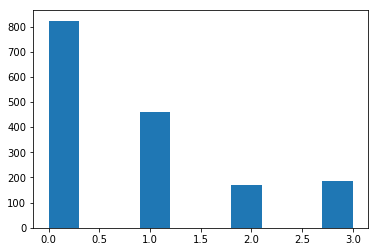

In [10]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(test_labels)

print(le.classes_)

plt.hist(y)

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()

In [12]:
print features.shape
print test_features.shape

(11732, 49)
(1638, 49)


In [139]:
#concat features_new and test_features_new

features_new_modified = features

feat = np.concatenate((features_new_modified, test_features), axis=0)

In [140]:
from sklearn import preprocessing

feat.shape
feat = preprocessing.scale(feat)
#a = np.array(preprocessing.scale(features_new))

In [141]:
feat.shape

(12085, 43)

In [144]:
feat[0]

array([-1.07871766, -0.54722184, -0.42512917,  1.93147395,  1.54025685,
        1.31500581, -1.16401787, -0.58565784, -0.49448442,  2.19180469,
        1.95816987,  1.93188337, -0.12769087, -0.09274514, -1.95714143,
       -0.11982581, -2.25241434,  0.71612811, -1.23164308,  0.52522573,
        0.35281807, -0.84841368,  0.02963811, -0.32673504, -0.25326001,
       -0.18325033,  0.14371802, -0.29819487,  1.51366491,  1.45490293,
        1.52880623,  2.44904285,  3.41701979,  2.22696858,  0.7279779 ,
        0.36058202,  0.61054846,  0.75755116,  0.56720344, -0.68495489,
        0.52522573,  0.35281807, -0.84841368])

In [143]:
feat[-1]

array([ 0.11387221,  0.34858027,  1.40236773, -0.41534214, -0.40690439,
       -0.35459478,  0.11792781,  0.3349446 ,  1.38988938, -0.61963034,
       -0.56443602, -0.54750434, -2.12869714, -0.16335732,  0.40179768,
       -0.1451961 ,  0.55047419,  1.34017378,  1.1392892 , -0.90400814,
       -1.06833251,  1.69104934,  0.41219797,  0.47929388,  0.10319025,
       -0.11034495, -0.52116462, 18.54889327, -0.43260115, -0.09793085,
       -0.77811948, -0.57912506, -0.52367265, -0.54682524, -0.15535772,
        0.0637886 ,  0.26366627, -1.15627329, -1.53763101,  1.39744902,
       -0.90400814, -1.06833251,  1.69104934])

In [145]:
feat.shape
test_features_scaled = feat[-test_features.shape[0]:]

In [146]:
test_features_scaled.shape

(353, 43)

(8584, 49)
(859, 49)
(859,)
0.8952270081490105
[0.93728223 0.85234899 0.89781022]
Confusion matrix, without normalization
[[269  13   4]
 [  9 254  24]
 [  9  31 246]]


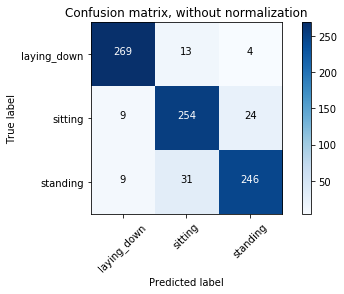

0.58568479008947
[0.85059423 0.45777027 0.29044118]
Confusion matrix, without normalization
[[501 239  83]
 [ 79 271 110]
 [  9  82  79]]


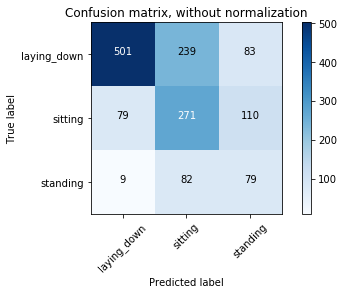

In [46]:
from sklearn.metrics import confusion_matrix
import itertools
from xgboost import XGBClassifier

print(features.shape)
#print(labels.shape)

le = preprocessing.LabelEncoder()

scaler = preprocessing.StandardScaler()
#X = scaler.fit_transform(features)
X = features

#X = np.array(preprocessing.scale(features))
y = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#model = LogisticRegression(penalty='l1')
#model = MLPClassifier(hidden_layer_sizes=(50,100), activation='tanh', solver='lbfgs', random_state=42, max_iter=500)
model = DecisionTreeClassifier(random_state=42, max_features=25, criterion='gini')
#model = XGBClassifier()
#model = RandomForestClassifier(n_estimators=40, criterion='gini', max_features=10, max_depth=15,random_state=42)
model.fit(X_train, y_train)


X = X_test
y = y_test
# X = np.array(normalize(test_features_new))
# y = le.transform(test_labels)

print(X.shape)
print(y.shape)

prediction = model.predict(X)

accuracy = metrics.accuracy_score(y, prediction)
precision = metrics.precision_score(y, prediction, average = None)
# recall = metrics.recall_score(y_test, prediction, average = None)

print(accuracy)
print(precision)

cnf_matrix = confusion_matrix(y,prediction)

plot_confusion_matrix(cnf_matrix, classes=le.classes_,
                      title='Confusion matrix, without normalization')

#X = scaler.fit_transform(features) 
#X = np.array(preprocessing.scale(features))
X = features
y = le.fit_transform(labels)

model.fit(X, y)


#X = scaler.transform(test_features)
X = test_features
#X = np.array(preprocessing.scale(test_features))
y = le.transform(test_labels)

#X = X_test
#y = y_test

#print(X.shape)
#print(y.shape)

prediction = model.predict(X)

accuracy = metrics.accuracy_score(y, prediction)
precision = metrics.precision_score(y, prediction, average = None)
# recall = metrics.recall_score(y_test, prediction, average = None)

print(accuracy)
print(precision)

cnf_matrix = confusion_matrix(y,prediction)

plot_confusion_matrix(cnf_matrix, classes=le.classes_,
                      title='Confusion matrix, without normalization')

# features[0]

In [168]:
test_features[0]
# test_labels[1]

array([ 8.31807172e+00, -2.58944945e+00,  4.85914690e+00,  6.24986504e-03,
        1.17784540e-01,  5.07473489e-02,  8.30593100e+00, -2.56119500e+00,
        4.89738750e+00,  7.90560879e-02,  3.43197524e-01,  2.25271722e-01,
        1.57666681e+01,  8.69848800e+00,  8.01869400e+00, -1.89097570e+00,
       -3.36545800e+00,  5.43356300e+00,  4.28461600e+00,  6.91965670e+01,
        6.82303298e+00,  2.36620559e+01,  6.39071407e-01,  2.73993922e+00,
       -3.11349839e-01, -1.13864841e+00, -3.68664008e-01, -8.84812916e-01,
        4.87291401e+00,  6.71606754e+00,  6.15313815e+00,  8.61715000e-02,
        6.51070000e-01,  3.85375850e-01, -2.15497234e+04, -1.25148214e+04,
        4.04075936e+04,  8.31844739e+03,  2.61209360e+03,  4.86436593e+03,
        6.91965670e+04,  6.82303298e+03,  2.36620559e+04])

In [85]:
from collections import Counter

c = Counter(y)

print(c)

Counter({3: 319, 2: 302, 0: 295, 1: 258})


In [110]:
le.classes_

array(['laying_down', 'sitting', 'standing', 'walking'], dtype='|S11')